In [1]:
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johns\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\johns\Documents\grip\env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#paths to datasets
stocks = 'C:\\Users\\johns\\Documents\\grip\\data\\prices.csv'
headlines = 'C:\\Users\\johns\\Documents\\grip\\data\\headlines.csv'

In [3]:
df_stcok_price = pd.read_csv(stocks)
print(df_stcok_price.head())
print(df_stcok_price.size)

         Date       Open       High        Low      Close
0  03/31/2022  58,779.71  58,890.92  58,485.79  58,568.51
1  03/30/2022  58,362.85  58,727.78  58,176.00  58,683.99
2  03/29/2022  57,814.76  58,001.53  57,639.35  57,943.65
3  03/28/2022  57,472.72  57,638.34  56,825.09  57,593.49
4  03/25/2022  57,801.72  57,845.37  57,100.24  57,362.20
1240


In [4]:
df_stcok_price['Date'] = pd.to_datetime(df_stcok_price.Date,format='%m/%d/%Y')

In [5]:
print(df_stcok_price.head())

        Date       Open       High        Low      Close
0 2022-03-31  58,779.71  58,890.92  58,485.79  58,568.51
1 2022-03-30  58,362.85  58,727.78  58,176.00  58,683.99
2 2022-03-29  57,814.76  58,001.53  57,639.35  57,943.65
3 2022-03-28  57,472.72  57,638.34  56,825.09  57,593.49
4 2022-03-25  57,801.72  57,845.37  57,100.24  57,362.20


In [7]:
#clearing the ',' from the prices 
for i in df_stcok_price.index:
    for m in df_stcok_price.columns.tolist()[1:]:
        df_stcok_price[m]= df_stcok_price[m].replace(df_stcok_price.iloc[i][m],df_stcok_price.iloc[i][m].replace(",",""))
print(df_stcok_price.head())

        Date      Open      High       Low     Close
0 2022-03-31  58779.71  58890.92  58485.79  58568.51
1 2022-03-30  58362.85  58727.78  58176.00  58683.99
2 2022-03-29  57814.76  58001.53  57639.35  57943.65
3 2022-03-28  57472.72  57638.34  56825.09  57593.49
4 2022-03-25  57801.72  57845.37  57100.24  57362.20


In [8]:
df_stcok_price['Date'] = pd.to_datetime(df_stcok_price['Date'])
df_stcok_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    248 non-null    datetime64[ns]
 1   Open    248 non-null    object        
 2   High    248 non-null    object        
 3   Low     248 non-null    object        
 4   Close   248 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 9.8+ KB


Text(0, 0.5, 'Close')

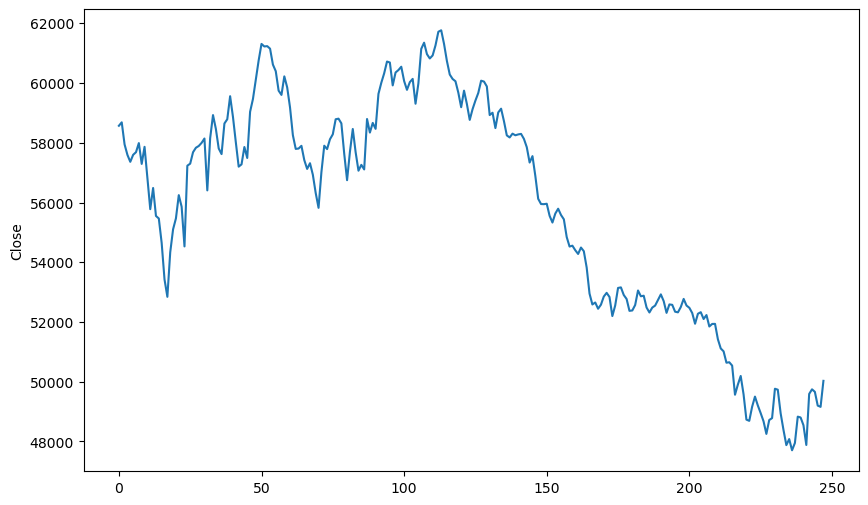

In [9]:
#eploration of the dataset 
df_stcok_price.dropna(inplace = True)
plt.figure(figsize=(10, 6))
df_stcok_price['Close'].astype('float64').plot()
plt.ylabel('Close')

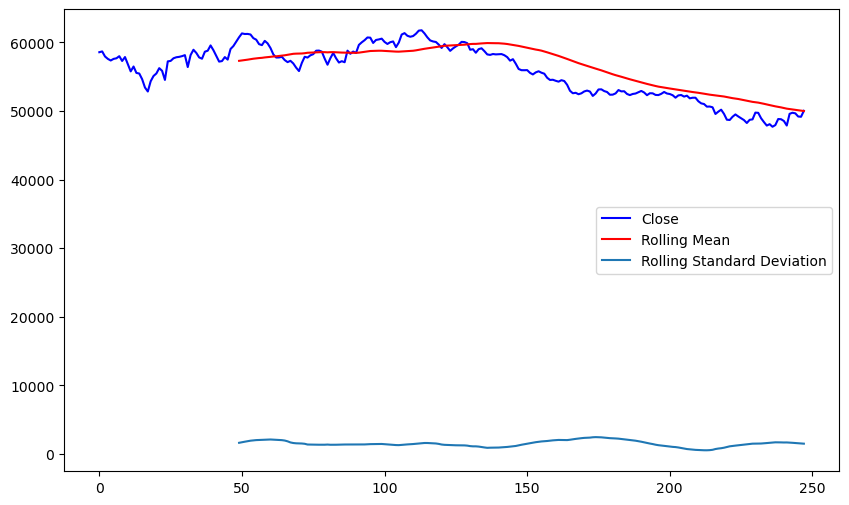

In [10]:
#Plotting moving average
close = df_stcok_price['Close'].astype('float64')
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_stcok_price['Close'].astype('float64').plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

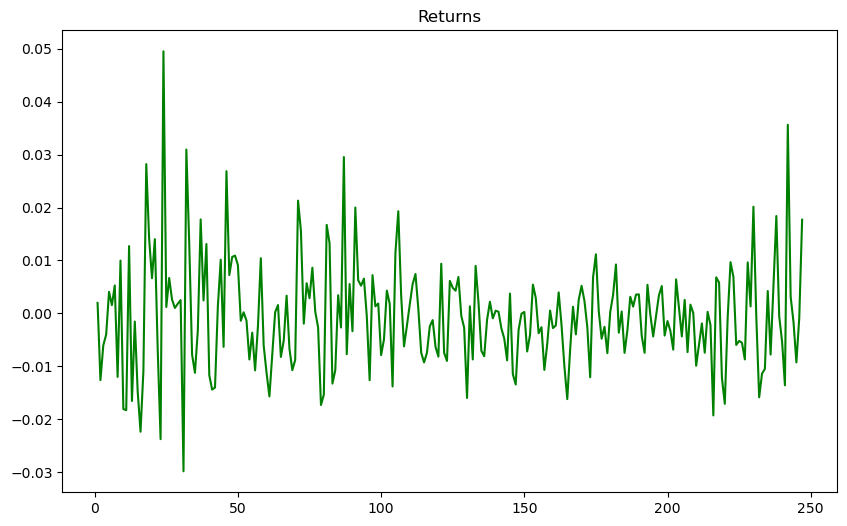

In [11]:
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [12]:
train = df_stcok_price[:200]
test = df_stcok_price[200:]

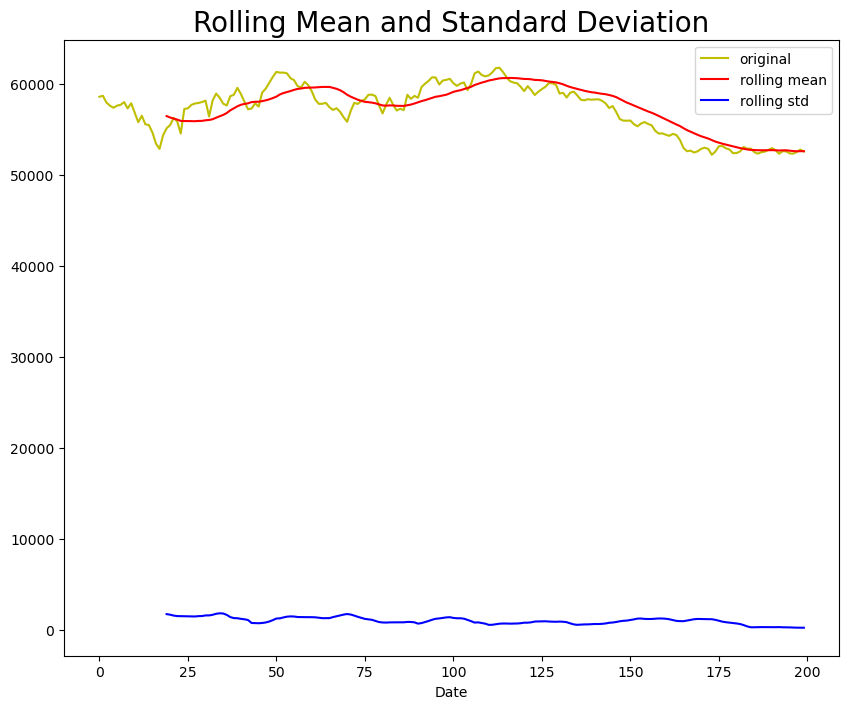

Results of dickey fuller test
ADF Test Statistic : -1.0471980251325816
p-value : 0.7356632519182914
#Lags Used : 0
Number of Observations Used : 199
Weak evidence against null hypothesis, time series is non-stationary 


In [13]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)
 
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'].astype('float64'))

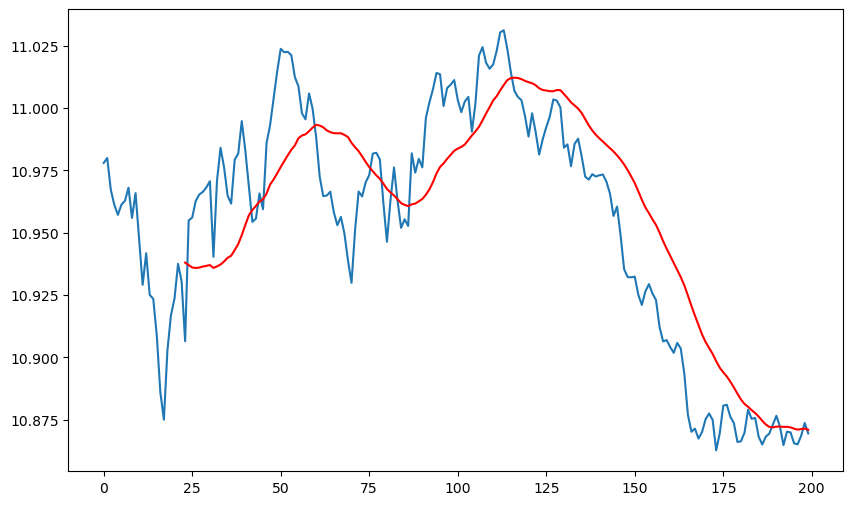

In [14]:
train_log = np.log(train['Close'].astype('float64')) 
test_log = np.log(test['Close'].astype('float64'))

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

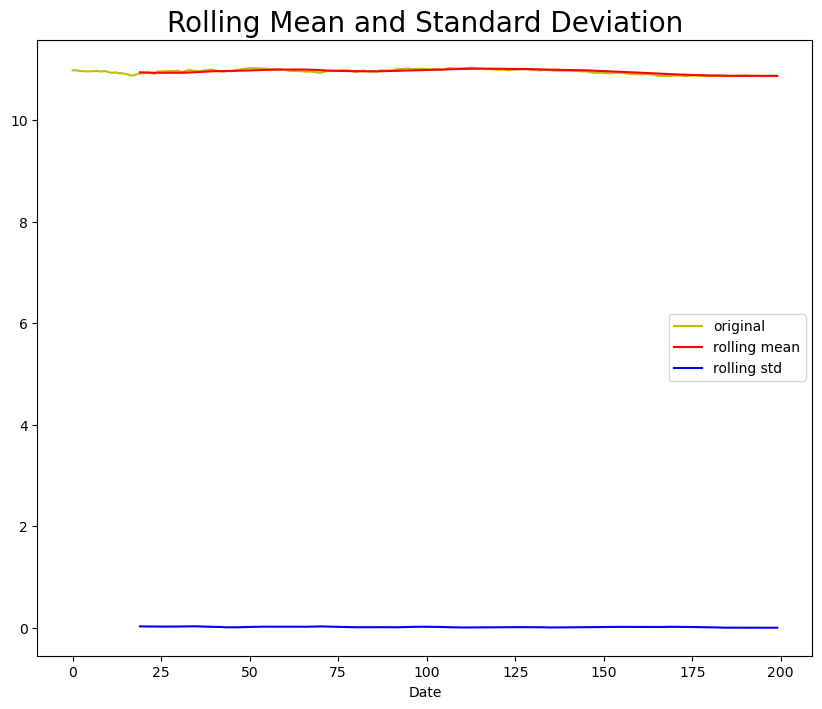

Results of dickey fuller test
ADF Test Statistic : -1.0126738071407044
p-value : 0.7486137998741832
#Lags Used : 0
Number of Observations Used : 199
Weak evidence against null hypothesis, time series is non-stationary 


In [15]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

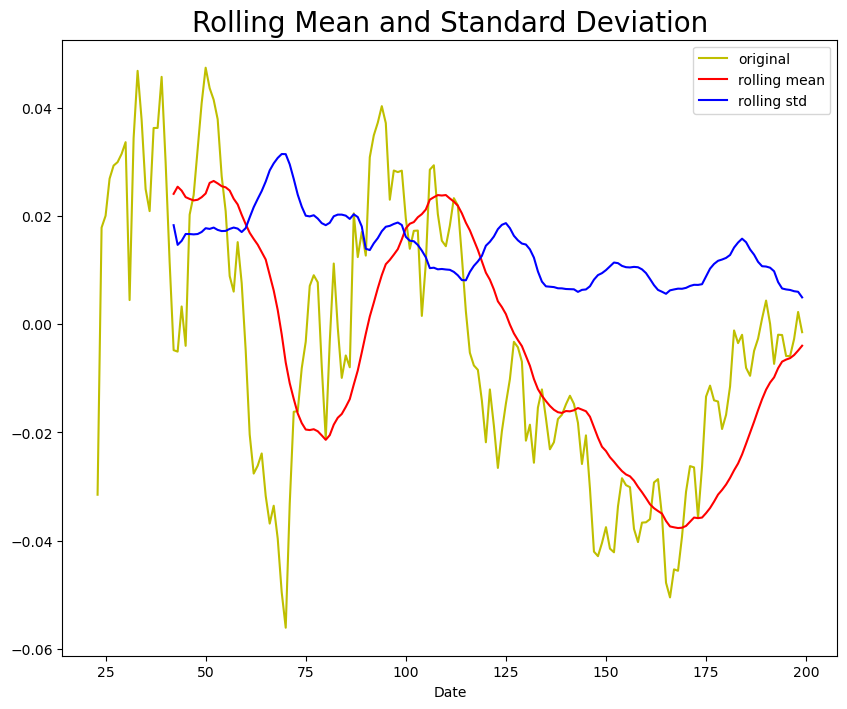

Results of dickey fuller test
ADF Test Statistic : -2.6901772885336053
p-value : 0.07575350549532506
#Lags Used : 1
Number of Observations Used : 175
Weak evidence against null hypothesis, time series is non-stationary 


In [16]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [18]:
#predictions based on stock prices alone
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1255.436, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1260.417, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1258.772, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1258.833, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1261.838, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1256.798, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.430 seconds


Text(0, 0.5, 'Actual Stock Price')

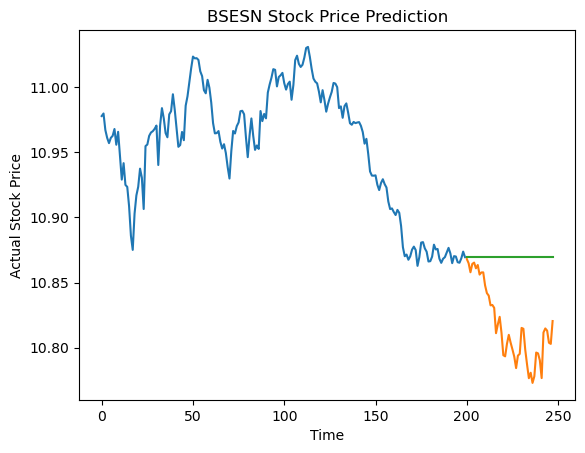

In [19]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [20]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.059663099948967964


In [21]:
cols = ['Date','Category','News']
df_news = pd.read_csv(headlines, names = cols)
df_news

C:\Users\johns\AppData\Local\Temp\ipykernel_9928\1813413397.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news = pd.read_csv(headlines, names = cols)


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [22]:
df_news = df_news.tail(300000)
df_news = df_news.reset_index()
df_news = df_news.drop('index',axis= 1)

In [23]:
df_news

,Date,Category,News
0,20200807,city.chandigarh,Mohali: Bajwa Developers managing director in ...
1,20200807,city.ahmedabad,Couple moves HC to talk to grandchild
2,20200807,city.kolkata,West Bengal CM warns against fake Covid tests
3,20200807,city.chandigarh,Elderly woman loses gold chain to snatchers
4,20200807,city.aurangabad,'Mission Zero Mortality' launched in Aurangabad
...,...,...,...
299995,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
299996,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
299997,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
299998,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [24]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299999 entries, 1 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    299999 non-null  object
 1   News    299999 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


In [25]:
 #Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2020-08-07,Couple moves HC to talk to grandchild
2,2020-08-07,West Bengal CM warns against fake Covid tests
3,2020-08-07,Elderly woman loses gold chain to snatchers
4,2020-08-07,'Mission Zero Mortality' launched in Aurangabad
5,2020-08-07,Bus with 30 passengers stolen from Sirsa bus s...
...,...,...
299995,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
299996,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
299997,2022-03-31,As Covid-19 cases drop to nil in southern dist...
299998,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [26]:

#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2020-08-07,Couple moves HC to talk to grandchild West Ben...
1,2020-08-08,Maoists into cultivation of ganja now; say Viz...
2,2020-08-09,Weekly Horoscope; 09-15 August 2020: Check pre...
3,2020-08-10,Samantha Akkineni wore the hottest wedding gue...
4,2020-08-11,Man held for objectionable posts on social med...
...,...,...
597,2022-03-27,Playing a dead man in Body God meant sitting i...
598,2022-03-28,As fashion becomes democratic; demand for styl...
599,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
600,2022-03-30,I will not give in to trends: Dossmode The tim...


In [27]:
df_news['News']

0      Couple moves HC to talk to grandchild West Ben...
1      Maoists into cultivation of ganja now; say Viz...
2      Weekly Horoscope; 09-15 August 2020: Check pre...
3      Samantha Akkineni wore the hottest wedding gue...
4      Man held for objectionable posts on social med...
                             ...                        
597    Playing a dead man in Body God meant sitting i...
598    As fashion becomes democratic; demand for styl...
599    Bobby Deol: Like my dad; I hope to be working ...
600    I will not give in to trends: Dossmode The tim...
601    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 602, dtype: object

In [28]:
ps = PorterStemmer()
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [29]:
df_news['News'] = pd.Series(c)
df_news

C:\Users\johns\AppData\Local\Temp\ipykernel_9928\71273463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['News'] = pd.Series(c)


,Date,News
0,2020-08-07,coupl move hc talk grandchild west bengal cm w...
1,2020-08-08,maoist cultiv ganja say vizag cop three half y...
2,2020-08-09,weekli horoscop august check predict zodiac si...
3,2020-08-10,samantha akkineni wore hottest wed guest outfi...
4,2020-08-11,man held objection post social media non sit a...
...,...,...
597,2022-03-27,play dead man bodi god meant sit refriger guru...
598,2022-03-28,fashion becom democrat demand stylist soar las...
599,2022-03-29,bobbi deol like dad hope work age yasha surya ...
600,2022-03-30,give trend dossmod time gave boyfriend incred ...


In [30]:

#Functions to get the subjectivity and polarity
def getSubjectivity(text):
      return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
      return  TextBlob(text).sentiment.polarity

In [31]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

C:\Users\johns\AppData\Local\Temp\ipykernel_9928\1226800301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
C:\Users\johns\AppData\Local\Temp\ipykernel_9928\1226800301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Polarity'] = df_news['News'].apply(getPolarity)


,Date,News,Subjectivity,Polarity
0,2020-08-07,coupl move hc talk grandchild west bengal cm w...,0.362409,0.044283
1,2020-08-08,maoist cultiv ganja say vizag cop three half y...,0.376563,0.057927
2,2020-08-09,weekli horoscop august check predict zodiac si...,0.369120,0.066621
3,2020-08-10,samantha akkineni wore hottest wed guest outfi...,0.340915,0.023987
4,2020-08-11,man held objection post social media non sit a...,0.371968,0.057915
...,...,...,...,...
597,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855
598,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270
599,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037
600,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339


<AxesSubplot:>

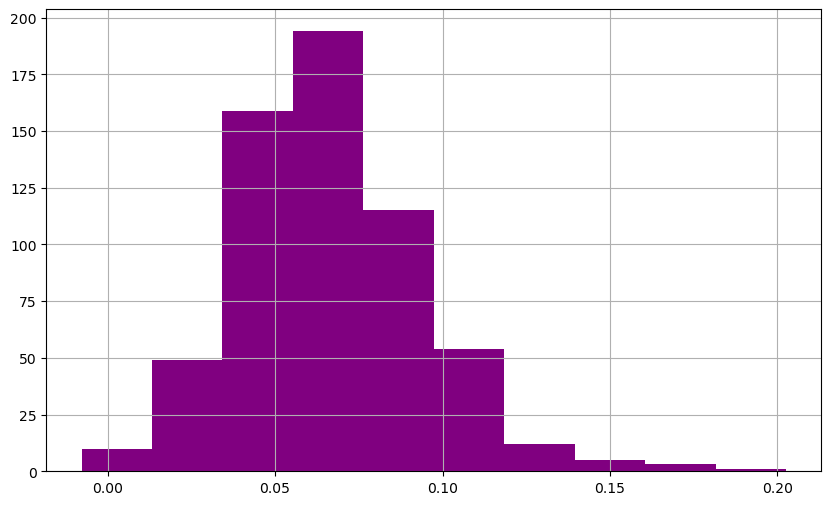

In [32]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

<AxesSubplot:>

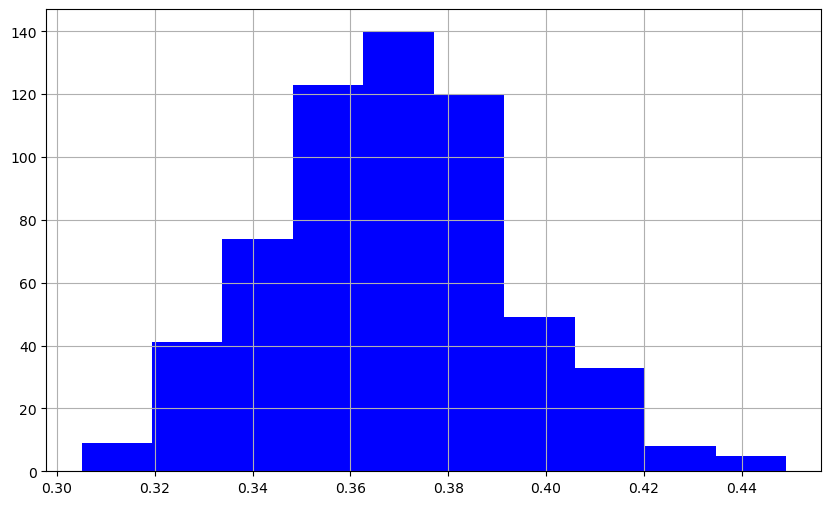

In [34]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [35]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

C:\Users\johns\AppData\Local\Temp\ipykernel_9928\2572001898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
C:\Users\johns\AppData\Local\Temp\ipykernel_9928\2572001898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
C:\Users\johns\AppData\Local\Temp\ipykernel_9928\2572001898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-08-07,coupl move hc talk grandchild west bengal cm w...,0.362409,0.044283,-0.9993,0.134,0.795,0.071
1,2020-08-08,maoist cultiv ganja say vizag cop three half y...,0.376563,0.057927,-0.9997,0.128,0.801,0.072
2,2020-08-09,weekli horoscop august check predict zodiac si...,0.369120,0.066621,-0.9999,0.156,0.778,0.066
3,2020-08-10,samantha akkineni wore hottest wed guest outfi...,0.340915,0.023987,-0.9999,0.154,0.784,0.061
4,2020-08-11,man held objection post social media non sit a...,0.371968,0.057915,-0.9999,0.156,0.786,0.058
...,...,...,...,...,...,...,...,...
597,2022-03-27,play dead man bodi god meant sit refriger guru...,0.356716,0.087855,-0.9999,0.149,0.782,0.069
598,2022-03-28,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
599,2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
600,2022-03-30,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067


In [36]:
#merging the datasets based on date
df_merge = pd.merge(df_stcok_price, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2022-03-31,58779.71,58890.92,58485.79,58568.51,shashank goe back coastal karnataka moggina ma...,0.311183,0.045025,-0.9998,0.130,0.808,0.061
1,2022-03-30,58362.85,58727.78,58176.00,58683.99,give trend dossmod time gave boyfriend incred ...,0.330696,0.052339,-0.9998,0.139,0.794,0.067
2,2022-03-29,57814.76,58001.53,57639.35,57943.65,bobbi deol like dad hope work age yasha surya ...,0.372864,0.083037,-0.9997,0.129,0.799,0.072
3,2022-03-28,57472.72,57638.34,56825.09,57593.49,fashion becom democrat demand stylist soar las...,0.382331,0.079270,-0.9998,0.144,0.778,0.078
4,2022-03-25,57801.72,57845.37,57100.24,57362.20,speed shortcut tackl unruli custom take deliv ...,0.377083,0.026320,-0.9999,0.146,0.795,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...
243,2021-04-08,49885.26,50118.08,49581.61,49746.21,fund state excav speaker undergo angioplasti a...,0.353266,0.064191,-0.9999,0.139,0.802,0.060
244,2021-04-07,49277.09,49900.13,49093.90,49661.76,exclus dua lipa india one magic place ahmedaba...,0.402565,0.072653,-0.9998,0.122,0.829,0.050
245,2021-04-06,49441.13,49582.26,48936.35,49201.39,gst asstt commission wife found hang suicid su...,0.413682,0.080515,-0.9999,0.140,0.807,0.054
246,2021-04-05,50020.91,50028.67,48580.80,49159.32,horoscop today april check astrolog predict ar...,0.420720,0.080734,-0.9999,0.150,0.782,0.068


In [37]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,58568.51,0.311183,0.045025,-0.9998,0.130,0.808,0.061
1,58683.99,0.330696,0.052339,-0.9998,0.139,0.794,0.067
2,57943.65,0.372864,0.083037,-0.9997,0.129,0.799,0.072
3,57593.49,0.382331,0.079270,-0.9998,0.144,0.778,0.078
4,57362.20,0.377083,0.026320,-0.9999,0.146,0.795,0.059
...,...,...,...,...,...,...,...
243,49746.21,0.353266,0.064191,-0.9999,0.139,0.802,0.060
244,49661.76,0.402565,0.072653,-0.9998,0.122,0.829,0.050
245,49201.39,0.413682,0.080515,-0.9999,0.140,0.807,0.054
246,49159.32,0.420720,0.080734,-0.9999,0.150,0.782,0.068


In [38]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.772608,0.051697,0.234427,0.00005,0.485149,0.704225,0.183333
1,0.780822,0.215180,0.276488,0.00005,0.574257,0.507042,0.283333
2,0.728165,0.568486,0.453032,0.00010,0.475248,0.577465,0.366667
3,0.703260,0.647800,0.431366,0.00005,0.623762,0.281690,0.466667
4,0.686810,0.603836,0.126855,0.00000,0.643564,0.521127,0.150000


In [39]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.051697,0.234427,0.00005,0.485149,0.704225,0.183333
1,0.215180,0.276488,0.00005,0.574257,0.507042,0.283333
2,0.568486,0.453032,0.00010,0.475248,0.577465,0.366667
3,0.647800,0.431366,0.00005,0.623762,0.281690,0.466667
4,0.603836,0.126855,0.00000,0.643564,0.521127,0.150000


In [40]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(198, 6)

In [41]:
#testing different models 
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
108,0.560475,0.275735,0.00005,0.544554,0.521127,0.316667
18,0.410003,0.197815,0.00000,0.623762,0.492958,0.233333
205,0.566395,0.053811,0.00015,0.306931,0.873239,0.283333
15,0.745621,0.444421,0.00005,0.653465,0.281690,0.416667
71,0.438934,0.343747,0.00005,0.534653,0.492958,0.350000
7,0.501841,0.349147,0.00000,0.603960,0.605634,0.116667
228,0.453828,0.854757,0.00035,0.445545,0.408451,0.616667
180,0.737552,0.424287,0.00000,0.564356,0.549296,0.250000
146,0.117481,0.554682,0.00010,0.534653,0.295775,0.600000
160,0.599747,0.316787,0.00005,0.613861,0.450704,0.283333


In [42]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [43]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.50008778 0.41628264 0.54991466 0.46921689 0.60986321 0.45639254
 0.62838237 0.51999912 0.3025767  0.67119327]
247    0.165296
168    0.336983
76     0.788125
150    0.587006
145    0.700337
73     0.717097
45     0.696007
159    0.487124
218    0.176925
213    0.208519
Name: Close, dtype: float64
0.07078737250353323


In [44]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)


In [45]:
print(mean_squared_error(predictions, y_test))

0.0691273212889851


In [46]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [47]:

print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.3319317  0.01732743 0.84610368 0.55832911 0.78082176 0.15624984
 0.92326343 0.14424398 0.30079254 0.96730819]
247    0.165296
168    0.336983
76     0.788125
150    0.587006
145    0.700337
73     0.717097
45     0.696007
159    0.487124
218    0.176925
213    0.208519
Name: Close, dtype: float64
0.11975587417885446


In [48]:

lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [49]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.07490651442739556


In [50]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

C:\Users\johns\Documents\grip\env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [51]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.08389669916648364
